# Chapter 6. Decision Trees

In this Chapter, we will start by discussing how to train, validate, and make predictions with decision trees. Then we will go through the CART training algorithm used by `Scikit-Learn`, we will discuss how to regularize trees and use them in regression tasks. Finally, we will discuss some of the limitations of decision trees.

## Training & Visualizing a Decision Tree

To understand decision trees, let's start by building one and taking a look at its predictions.

In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

In [2]:
iris = load_iris()

In [3]:
X = iris.data[:, 2:]  # Petal length and width
y = iris.target
X.shape, y.shape

((150, 2), (150,))

In [4]:
tree_clf = DecisionTreeClassifier(max_depth=2)

In [5]:
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

We can visualize the decision tree by using the `export_graphiz()` method to export a graph representation file then taking a look at it:

In [6]:
from sklearn.tree import export_graphviz

In [7]:
export_graphviz(tree_clf, 
                out_file='models/06/iris_tree.dot', 
                feature_names=iris.feature_names[2:],
                class_names=iris.target_names,
                rounded=True,
                filled=True)

Let's convert the graph file into a .png file:

In [8]:
! dot -Tpng models/06/iris_tree.dot -o static/imgs/iris_tree.png

And here it is:

<div style="text-align:center"><img style="width:33%" src="static/imgs/iris_tree.png"></div>

## Making Predictions

To classify a new data point, we start at the root node of the graph (on the top), and we answer the binary questions and we reach the end leaf. That end leaf represents your class.

One of the many qualities of decision trees is that they require very little data preparation. In fact, they don't require feature scaling or centering at all!

A tree node has the following attributes:
- `samples`: counts how many training instances are sitting on the node.
- `value`: tells us how many instances of each class are setting on the node.
- `gini`: measures the nodes impurity (pure == 0)

The following equation shows how the training algorithm computes the gini scores of the ith node:

$$G_i=1-\sum_{k=1}^n{p_{i,k}}^2$$

Where $p_{i,k}$ is the ratio of class $k$ instances among the training instances in that particular node. In our case: $k \in \{1,2,3\}$.

`Scikit-learn` uses the CART algorithm, which produces only binary trees. Non-leaf nodes only have two children.

However, other algorithms such as ID3 can produce decision trees with nodes that have more than 2 children.

The following figure shows the decision boundaries of our decision tree (Decision Trees tend to create lines/rectangles/boxes/.. and split the feature space linearly but iteratively):
 
<div style="text-align:center"><img style="width:50%" src="static/imgs/decision_tree_boundaries.png"></div>

All in all, decision Trees are intuitive, and their predictions are easily interpretable. These types of models are called **white box** models.

In contrast, as we will see, Random Forests and Neural Networks are generally considered Black Box models.

## Estimating Class Probabilities

A decision tree can also estimate the probability that a certain instance belongs to a certain class. It just returns the ratio of that class over the sum of all instances in the leaf.

Let's check this in scikit-learn:

In [9]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [10]:
tree_clf.predict([[5, 1.5]])

array([1])

Interesting insight: we'll get the same probability as long as we're in a certain leaf box. It doesn't matter if our new data point gets closer to the decision boundaries.

## The CART Training Algorithm

Scikit-Learn uses the Classification and Regression Tree (CART) algorithm to train decision trees (also called "growing" trees). The algorithm works by first splitting the training set by feature $k$ and threshold $t_k$.

It chooses $k$ and $t_k$ by searching for the $(k,t_k)$ that produce the purest subsets weighted by their size.

The following figure gives the loss function that CART tries to minimize:

$$J(k,t_k)=\frac{m_{left}}{m}G_{left} + \frac{m_{right}}{m}G_{right}$$

Where:
- $G_{left/right}$ measures the resulted impurity in the left/right subsets.
- $m_{left/right}$ correspond to the number of instances in the left/right subsets.

Once the CART algorithm successfully split the initial training data into two subsets, it does the same thing to both subsets. It stops recursing once it reaches the maximum allowed tree depth (the `max_depth` hyper-parameter), or if it cannot find a split that reduces impurity.

Other hyper-parameters that control stopping include: `min_samples_split`, `min_samples_leaf`, `min_weight_fraction_leaf`, `max_leaf_nodes`.

The CART algorithm is greedy in the sense that it doesn't care if its current split will lead to an optimal downstream leaf. It only cares about finding the best possible split at the current leaf. In that sense, it doesn't necessarily result in an optimal solution.

Unfortunately, finding the optimal tree is known to be an **NP-Complete** problem with a complexity of $O(exp(m))$.

## Computational Complexity

Making a prediction requires us to go from the root the final leaf.

Decision trees are approximately balanced, so traversing the decision tree require going through roughly $O(log_{2}(m))$. Since each node requires check the value of only one feature, the overall inference running time is $O(log_{2}(m))$. Which makes the algorrithm independent of the number of features. So predictions are really fast, even when the algorithm is dealing with a large number of features.

The training algorithm compares all features (except if `max_features` is set) on all samples at each node, this results in a training complexity of $O(n \times mlog_2(m))$.

For small training sets (less than a few thousands), scikit-learn can speed up training by presorting the data.

## Gini Impurity or Entropy?

In information theory, entropy is zero when all messages are identical.

In ML, entropy is often used as an impurity measure. A set's entropy is zero when **it contains instances of only one class**.

The following formula shows the entropy at node $i$:

$$H_i=-\sum_{k=1}^{n}p_{i,k}log_2(p_{i,k})$$

There's no big difference between using Gini or Entropy to measure impurity. Gini impurity is slightly faster to compute. 

When they differ, Entropy tends to produce more balanced trees.

## Regularization Hyperparameters

**Decision Trees make very few assumptions about the training data**. If left unconstrained, a decision tree will adapt itself to perfectly fit the training data. which naturally leads to overfitting.

Such a model is often called a *non-parameteric model* because the number of parameters is not determined before training.

We can at least restrict the maximum depth of the decision tree, among other regularization hyper-parameters:
- `min_samples_split`: The minimum number of samples a node must have for it to split.
- `min_samples_leaf`: The minimum number of samples a leaf must have.
- `min_weight_fraction_leaf`: `mean_samples_leaf` as a fraction.
- `max_leaf_nodes`: the maximum number of leaf nodes.
- `max_features`: The maximum number of features that are evaluated for any split.

The following figure shows two decision trees trained on the same moon dataset, the left one represent an unconstrained trained decision tree, and the right one is regularized using the `min_samples_leaf` hyper-parameter:

<div style="text-align:center"><img style="width:50%" src="static/imgs/regularized_tree.png"></div>

## Regression

Decision Trees are also capable of performing regression tasks.

Let's try it using scikit-learn:

In [11]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

In [12]:
# First we want to generate a noisy quadratic dataset
X = np.linspace(start=0, stop=1, num=500)
y = (X-0.5)**2 + np.random.randn(500)/50.

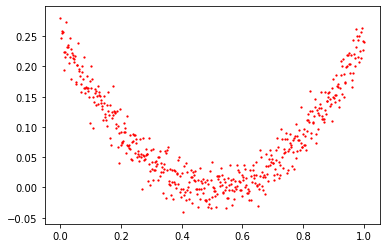

In [13]:
plt.scatter(X, y, s=1.5, c='red')

In [14]:
tree_reg = DecisionTreeRegressor(max_depth=2)

In [15]:
tree_reg.fit(X[..., None], y[..., None])

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Let's check the resulting tree:

In [16]:
export_graphviz(tree_reg, 
                out_file='models/06/reg_tree.dot', 
                feature_names=['X'],
                class_names=['y'],
                rounded=True,
                filled=True)

In [17]:
! dot -Tpng models/06/reg_tree.dot -o static/imgs/reg_tree.png

<div style="text-align:center"><img style="width:50%" src="static/imgs/reg_tree.png"></div>

This tree looks very similar to the classification tree we built earlier. The main difference is that instead of predicting a class for each node, it predicts a value. the prediction represents the average target value for the group in the leaf.

As we increase the `max_depth` hyper-parameter, we provide the regression tree with more flexibility, the following showcases tree predictions in red:

<div style="text-align:center"><img style="width:66%" src="static/imgs/regression_trees.png"></div>

The CART algorithm works almost the same as before, but instead of searching for a split that minimizes impurity, it searches for a split that produce balanced samples per leaf and minimize $MSE$.

We show the cost function that the algorithm tries to minimize:

$$J(k,t_k)=\frac{m_{left}}{m}MSE_{left} + \frac{m_{right}}{m}MSE_{right} \\ MSE=\frac{1}{m}\sum_{i=1}^{m}(\hat{y}_{i}-y_{i})^{2}$$

Just like classification, regression trees are prone to overfitting the training data, without any regularization, we endup with the plot on the left, and setting `min_samples_leaf=10` produce a much reasonable model:

<div style="text-align:center"><img style="width:66%" src="static/imgs/regularizing_trees.png"></div>

## Instability

Decision Trees have a few limitations:
- Decision Trees love orthogonal decision boundaries, which makes them sensitive to training set rotation. One way to limit this problem is to use PCA (Principal Component Analysis) which often results in a better orientation of the training data.
- Decision Trees are sensitive to small variations in the training data. In fact, because scikit-learn uses stochastic optimization, you might get different models for the same training dataset.

Random Forests can solve this problem by averaging incoming prediction from many decision trees.

---

# Exercices

**1. What is the approximate depth of a decision tree trained without restrictions on a training set with 1 million instances?**

If the tree is balanced, then at every layer it splits the samples in two, so the depth is $log_{2}(1\,000\,000) \approx 20$. Acutally a bit more since the tree won't be perfectly balanced.

**2. Is a node's Gini impurity generally lower or greater than its parent's? Always Lower/greater?**

Gini's impurity score is generally lower than its parent. However, it is possible for a child node to have higher Gini's score as long as it's compensated by its other binary node and by the weights of its sample size.

**3. If a decision tree is overfitting the training set, is it a good idea to try decreasing `max_depth`?**

Yes, It's a good idea since you're contraining the model's predictions to bigger `sample_size` averages.

**4. If a decision tree is underfitting the training set, is it a good idea to try scaling the input features?**

Decision Trees don't need feature scaling for them to work, you can reduce underfitting by increasing `max_depth`, decreasing `min_leaf_samples` or any of the other regularization hyper-parameters.

**5. If it takes one hour to train a decision tree on a training set containing one million instances, roughly how much time it would take it on a 10M training set?**

$11.66$hours.

**6. If your training set contains 100K instances, will setting `presort=True` speedup training?**

No, sorting data will only boost performance when you have instance on the scale of less than a few thousands.

**7. Train & Fine-tune a decision tree for the moons dataset by following these steps:**

a. Use `make_moons(n_samples=10000, noise=0.4)` to generate a moons dataset 

In [20]:
import sklearn
from sklearn.datasets import make_moons

In [21]:
X, y = make_moons(n_samples=10000, noise=0.4)

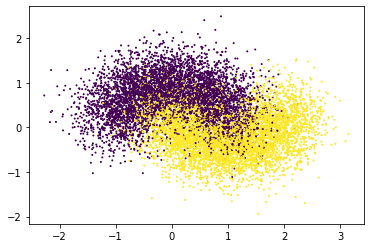

In [26]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
plt.show()

b. Use `train_test_split()` to split the data into a training set and a test test:

In [27]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7000, 2), (7000,), (3000, 2), (3000,))

c. Use grid search with cross validation (with the help of the `GridSearchCV`) to find good hyper-parameter values for a `DecisionTreeClassifier`

*Hint: Try various values for `max_leaf_nodes`*

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [31]:
clf = DecisionTreeClassifier()

In [39]:
param_grid = {
    'max_leaf_nodes': [3, 4, 5, 6, 7]
}

In [40]:
grid_searcher = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1)

In [41]:
grid_searcher.fit(X_train, y_train)

/Users/mohamedakramzaytar/opt/miniconda3/envs/research/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_leaf_nodes': [3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [42]:
grid_searcher.best_score_

0.8587142857142858

In [43]:
grid_searcher.best_params_

{'max_leaf_nodes': 4}

d. Train it on the full training set using these hyper-parameters, and measure your model's performance on the test set.

*You should get roughly 85% to 87% accuracy*

In [45]:
clf = DecisionTreeClassifier(max_leaf_nodes=4)

In [46]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=4, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [47]:
clf.score(X_test, y_test)

0.858

**8. Grow a Forest by following these steps**

a. Continuing the previous exercice, generate a 1,000 subsets of the training set, each containing a 100 instances selected randomly. 

*Hint: you can use scikit-learn's `ShuffleSplit` class for this*

In [100]:
from sklearn.model_selection import ShuffleSplit

In [101]:
rs = ShuffleSplit(n_splits=1000, train_size=100, test_size=0)

b. Train one decision tree on each subset, using the best hyper-parameter values found in the previous exercice. Evaluate these 1,000 decision trees on the test set. Since they were trained on smaller sets, these decision trees will likely perform worse than the first decision tree, achieving only aboyt 80% accuracy.

In [102]:
decision_trees = list()
ds_test_scores = list()

for train_idxs, _ in rs.split(X_train, y_train):
    
    # get sample
    x_bs = X_train[train_idxs]
    y_bs = y_train[train_idxs]
    
    # train decision tree
    clf = DecisionTreeClassifier(max_leaf_nodes=4)
    clf.fit(x_bs, y_bs)
    decision_trees.append(clf)
    
    # evaluate decision tree
    ds_test_scores.append(clf.score(X_test, y_test))
    
    # delete model
    del(clf)

c. Now comes the magic. For each test set instance, generate the predictions of the 1,000 decision trees, and keep only the most frequent prediction. This approach gives you *majority-vote* predictions over the test set.

In [103]:
from scipy.stats import mode

In [104]:
all_preds = list()
for tree in decision_trees:
    all_preds.append(tree.predict(X_test).tolist())

In [105]:
trees_preds = np.array(all_preds)
trees_preds.shape

(1000, 3000)

In [106]:
preds, _ = mode(trees_preds, axis=0)

d. Evaluate these predictions on the test set: you should obtain a slightly higher accuracy than your first model (about 0.5% to 1.5% higher).

*Congratulations, You have trained a random forest classifier!*

In [108]:
sum(preds.squeeze() == y_test)/len(y_test)

0.8603333333333333

---